In [1]:
import SimpleITK as sitk
from pathlib import Path
from tqdm import tqdm
from scipy import ndimage
import pandas as pd
from utils import parse_points_reg, compute_TRE

from synthmorph_preprocess import register_image
import torch 
import tensorflow as tf
import nibabel as nib
import numpy as np

from voxelmorph.tf.utils import point_spatial_transformer

/home/vzalevskyi/anaconda3/envs/mira/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-14 13:13:40.723132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 13:13:41.096890: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-14 13:13:42.786362: W tensorflow/compiler/xla/stream_executor/pla

In [2]:
import matplotlib.pyplot as plt

In [3]:
# processed_dir = Path('processed_data').mkdir(exist_ok=True)
data_dir = Path('processed_data/')
min_max_filter = sitk.MinimumMaximumImageFilter()

In [5]:
 for dataset in data_dir.iterdir():
        if not dataset.is_dir():
            continue
        cases = []
        with open(dataset/'train_cases.txt') as f:
            cases.extend(f.readlines())
        with open(dataset/'val_cases.txt') as f:
            cases.extend(f.readlines())
        cases = [case.strip() for case in cases]
        
        cases_path = (Path('processed_data')/dataset.name)/'scans/'
        cases_path.mkdir(parents=True, exist_ok=True)
        masks_path = (Path('processed_data')/dataset.name)/'lungMasks/'
        masks_path.mkdir(parents=True, exist_ok=True)
        
        for case in tqdm(cases):
            fixed_image = sitk.ReadImage(str(dataset/'scans'/f'{case}_insp.nii.gz'))
            moving_image = sitk.ReadImage(str(dataset/'scans'/f'{case}_exp.nii.gz'))
            fixed_mask = sitk.ReadImage(str(dataset/'lungMasks'/f'{case}_insp.nii.gz'))
            moving_mask = sitk.ReadImage(str(dataset/'lungMasks'/f'{case}_exp.nii.gz'))
            break
        break


  0%|          | 0/20 [00:00<?, ?it/s]


In [9]:

# transformixImageFilter = sitk.TransformixImageFilter()
# transformixImageFilter.LogToConsoleOff()
# # set moving image to initialize object correctly
# transformixImageFilter.SetMovingImage(moving_image)

# # register scans INVERSLY to transform points
# __, transformParameterMap = register_image(fixed_image=moving_image, moving_image=fixed_image, interpolator=None, param_set='affine')

# # set previously obtained transformation parameters
# transformixImageFilter.SetTransformParameterMap(transformParameterMap)

# read key points csv file
kps = pd.read_csv(dataset/'keypoints'/f'{case}.csv', header=None).values.astype(int)


In [10]:
moving_kps = kps[:, [3, 4, 5]]
fixed_kps = kps[:, [0, 1 ,2]]
print(compute_TRE(moving_kps, fixed_kps, moving_image.GetSpacing()))

(10.995582577849921, 5.811832628179803)


moving_l.max() 2628
fixed_l.max() 3005


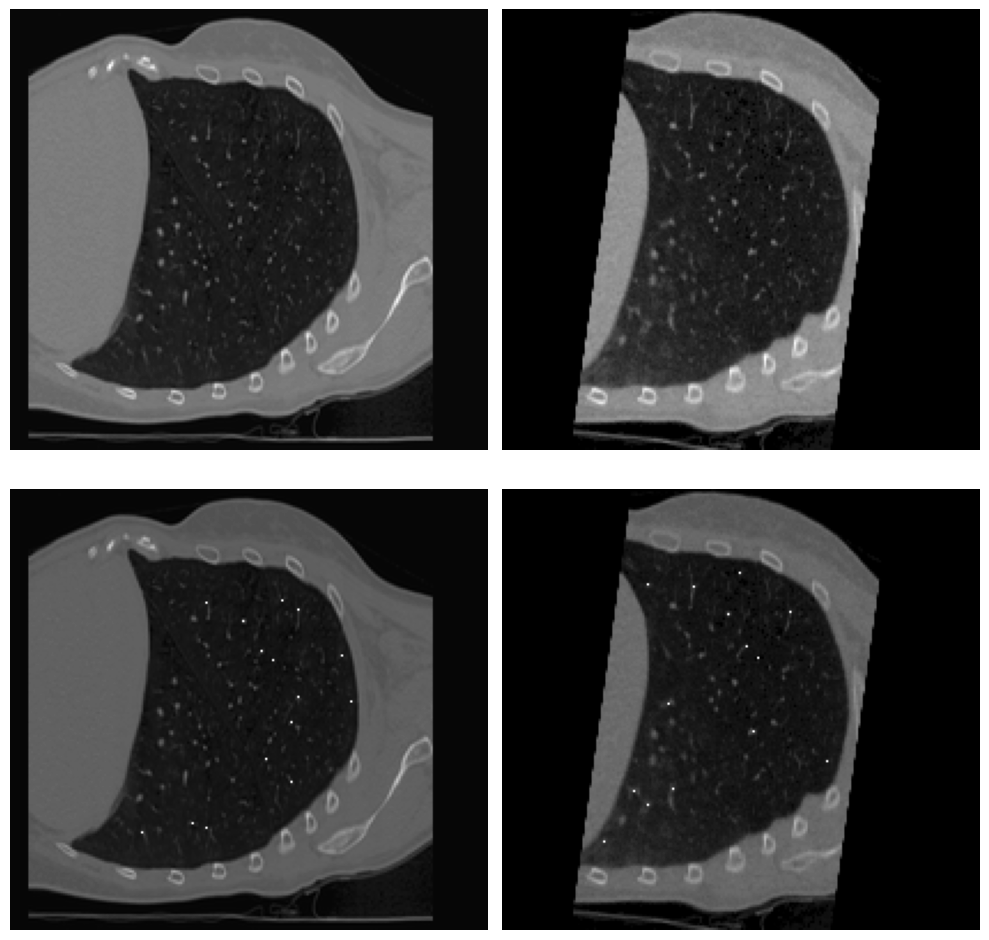

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))


# sitk -> xyz
# numpy -> zyx
moving_image_a = sitk.GetArrayFromImage(moving_image).T
fixed_image_a = sitk.GetArrayFromImage(fixed_image).T

moving_l = moving_image_a.copy()
fixed_l = fixed_image_a.copy()

# moving_l[moving_kps] = moving_l.max()
# fixed_l[fixed_kps] = fixed_l.max()

for p in fixed_kps:
    moving_l[p[0], p[1], p[2]] = moving_l.max()

print('moving_l.max()', moving_l.max())
for p in moving_kps:
    fixed_l[p[0], p[1], p[2]] = fixed_l.max()
print('fixed_l.max()', fixed_l.max())

s = 40
axs[0,0].imshow(fixed_image_a[s, :, :], cmap='gray')
axs[0,0].axis('off')
axs[0, 1].imshow(moving_image_a[s, :, :], cmap='gray')
axs[0,1].axis('off')
axs[1,0].imshow(fixed_l[s, :, :], cmap='gray')
axs[1,0].axis('off')
axs[1,1].imshow(moving_l[s, :, :], cmap='gray')
axs[1,1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
moving_image.SetPixel()

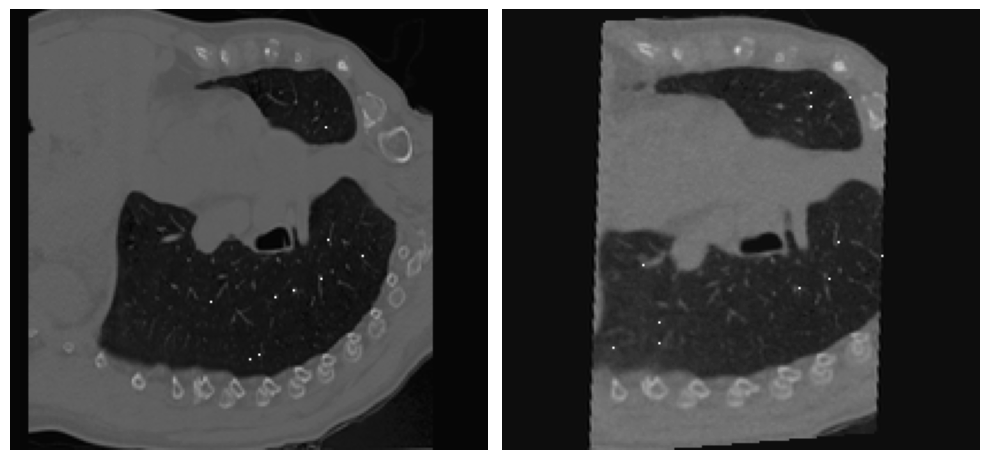

In [16]:
fixed_image = sitk.ReadImage(str(dataset/'scans'/f'{case}_insp.nii.gz'))
moving_image = sitk.ReadImage(str(dataset/'scans'/f'{case}_exp.nii.gz'))


# sitk -> xyz
# numpy -> zyx


# moving_l[moving_kps] = moving_l.max()
# fixed_l[fixed_kps] = fixed_l.max()

for p in fixed_kps:
    moving_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 1)


for p in moving_kps:
    fixed_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 1)



moving_l = sitk.GetArrayFromImage(moving_image)
fixed_l = sitk.GetArrayFromImage(fixed_image)
s = 80


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fixed_l.T[s, :, :], cmap='gray')
axs[0].axis('off')
axs[1].imshow(moving_l.T[s, :, :], cmap='gray')
axs[1].axis('off')
plt.tight_layout()
plt.show()

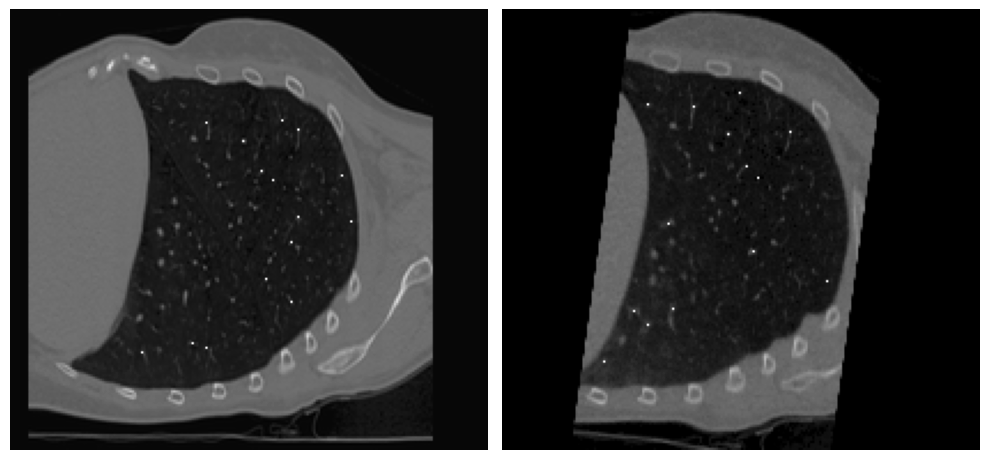

In [58]:
fixed_image = sitk.ReadImage(str(dataset/'scans'/f'{case}_insp.nii.gz'))
moving_image = sitk.ReadImage(str(dataset/'scans'/f'{case}_exp.nii.gz'))


# sitk -> xyz
# numpy -> zyx


# moving_l[moving_kps] = moving_l.max()
# fixed_l[fixed_kps] = fixed_l.max()

for p in fixed_kps:
    moving_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 2628)


for p in moving_kps:
    fixed_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 2628)



moving_l = sitk.GetArrayFromImage(moving_image)
fixed_l = sitk.GetArrayFromImage(fixed_image)
s = 40


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fixed_l.T[s, :, :], cmap='gray')
axs[0].axis('off')
axs[1].imshow(moving_l.T[s, :, :], cmap='gray')
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:


with open(dataset/'moving_kpts.pts', 'w') as f:
    f.write('index\n')
    f.write(str(len(moving_kps))+'\n')
    for i, kp in enumerate(moving_kps):
        f.write(f'{kp[2]} {kp[1]} {kp[0]}\n')


# set points to transform (inhale)
transformixImageFilter.SetFixedPointSetFileName(str(dataset/'moving_kpts.pts'))
transformixImageFilter.SetOutputDirectory(str(dataset))
transformixImageFilter.Execute()

moved_kps = parse_points_reg(str(dataset/'outputpoints.txt'))

In [42]:
# Load preprocessed data (scaled between 0 and 1 and with the moving data in the space of the fixed one)
fixed = nib.load("processed_data/learn2reg/scans/case_001_insp.nii.gz")
fixed_a = fixed.get_fdata()
moving = nib.load("processed_data/learn2reg/scans/case_001_exp.nii.gz")
moving_a = moving.get_fdata()
kps = pd.read_csv("processed_data/learn2reg/keypoints/case_001.csv", header=None).values
moving_img_trsf = nib.load("registered_data_pytorch.nii.gz")
    
moving_kps = kps[:, [0, 1, 2]]
fixed_kps = kps[:, [3, 4, 5]]

pos_flow = np.load("pos_flow.npy")
neg_flow = np.load("neg_flow.npy")

# # print(moving.shape, moving.max(), moving.min())
# # These data are in my local computer but any data could be used to perform the same analysis.
# # It only needs to be scaled and set in a common space

# Load the PyTorch model and specify the device
device = 'cpu'
pt_model_inference = torch.load('pt_smshapes.pt')
pt_model_inference.eval()

# # Prepare the data for inference
# data_moving = np.expand_dims(moving.get_fdata().squeeze(), axis=(0, -1)).astype(np.float32)
# data_fixed = np.expand_dims(fixed.get_fdata().squeeze(), axis=(0, -1)).astype(np.float32)

# # Set up tensors and permute for inference
# input_moving = torch.from_numpy(data_moving).to(device).float().permute(0, 4, 1, 2, 3)
# input_fixed = torch.from_numpy(data_fixed).to(device).float().permute(0, 4, 1, 2, 3)

annotations = moving_kps[:, [0, 1, 2]]
annotations = annotations[np.newaxis, ...]

print(neg_flow.shape)
neg_flow_reshaped = np.moveaxis(neg_flow, [1], [4])
print(neg_flow_reshaped.shape)
# warp annotations
data = [tf.convert_to_tensor(f, dtype=tf.float32) for f in [annotations, neg_flow_reshaped]]
moving_transformed = point_spatial_transformer(data)[0, ...].numpy()
spc = [1.75, 1.25, 1.75]
print('Before: ', compute_TRE(moving_kps, fixed_kps, spc), )
print('After: ', compute_TRE(moving_transformed, fixed_kps, spc) )

(1, 3, 192, 192, 208)
(1, 192, 192, 208, 3)
Before:  (19.039122999762032, 6.8812335706800125)
After:  (20.64849765379181, 10.308480809640578)


In [45]:
# fixed_image = sitk.ReadImage("data/copd_scans/scans/case_001_insp.nii.gz")
# moving_image = sitk.ReadImage('data/copd_scans/scans/case_001_exp.nii.gz')

# kps = pd.read_csv("data/copd_scans/keypoints/case_001.csv", header=None).values

    
moving_kps = kps[:, [0, 1, 2]]
fixed_kps = kps[:, [3, 4, 5]]

mov_voxels = []
fix_voxels = []


for p in fixed_kps:
    fix_voxels.extend(fixed_image[int(p[0])-1:int(p[0])+1, int(p[1])-1:int(p[1])+1, int(p[2])-1:int(p[2])+1])
for p in moving_kps:
    mov_voxels.extend(moving_image[int(p[0])-1:int(p[0])+1, int(p[1])-1:int(p[1])+1, int(p[2])-1:int(p[2])+1])

mov_voxels = np.asarray(mov_voxels)
fix_voxels = np.asarray(fix_voxels)

# for p in moving_kps:
#     moving_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 1)


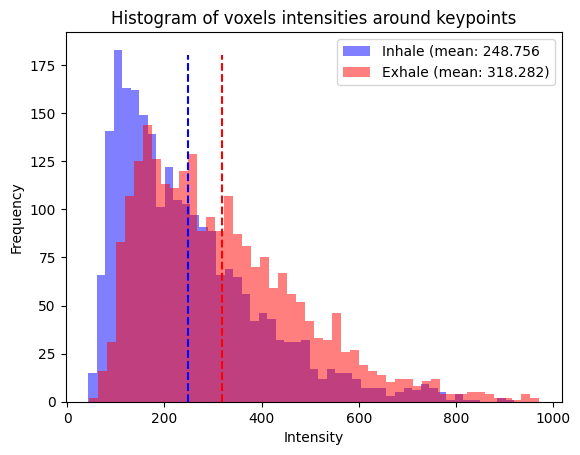

In [61]:
plt.hist(fix_voxels, bins=50, alpha=0.5, color='b')
plt.hist(mov_voxels, bins=50, alpha=0.5, color='r')
plt.legend([f'Inhale (mean: {fix_voxels.mean():.3f}', f'Exhale (mean: {mov_voxels.mean():.3f})'])

plt.vlines(fix_voxels.mean(), 0, 180, colors='b', linestyles='dashed')
plt.vlines(mov_voxels.mean(), 0, 180, colors='r', linestyles='dashed')
plt.title('Histogram of voxels intensities around keypoints')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

In [12]:

pos_flow = np.load("pos_flow.npy")
neg_flow = np.load("neg_flow.npy")

print(kps)

# # print(moving.shape, moving.max(), moving.min())
# # These data are in my local computer but any data could be used to perform the same analysis.
# # It only needs to be scaled and set in a common space

# Load the PyTorch model and specify the device
device = 'cpu'
pt_model_inference = torch.load('pt_smshapes.pt')
pt_model_inference.eval()

# # Prepare the data for inference
# data_moving = np.expand_dims(moving.get_fdata().squeeze(), axis=(0, -1)).astype(np.float32)
# data_fixed = np.expand_dims(fixed.get_fdata().squeeze(), axis=(0, -1)).astype(np.float32)

# # Set up tensors and permute for inference
# input_moving = torch.from_numpy(data_moving).to(device).float().permute(0, 4, 1, 2, 3)
# input_fixed = torch.from_numpy(data_fixed).to(device).float().permute(0, 4, 1, 2, 3)

annotations = moving_kps[:, [0, 1, 2]]
annotations = annotations[np.newaxis, ...]

print(neg_flow.shape)
neg_flow_reshaped = np.moveaxis(neg_flow, [1], [4])
print(neg_flow_reshaped.shape)
# warp annotations
data = [tf.convert_to_tensor(f, dtype=tf.float32) for f in [annotations, neg_flow_reshaped]]
moving_transformed = point_spatial_transformer(data)[0, ...].numpy()

[[ 25.    107.     66.     20.238  88.573  53.086]
 [ 28.     65.     65.     27.683  48.304  47.003]
 [ 28.     85.     64.     25.347  66.462  45.957]
 ...
 [171.     90.     64.    172.93   78.162  51.243]
 [171.     95.     91.    171.701  86.416  86.832]
 [171.     98.     74.    173.743  87.008  64.952]]
(1, 3, 192, 192, 208)
(1, 192, 192, 208, 3)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


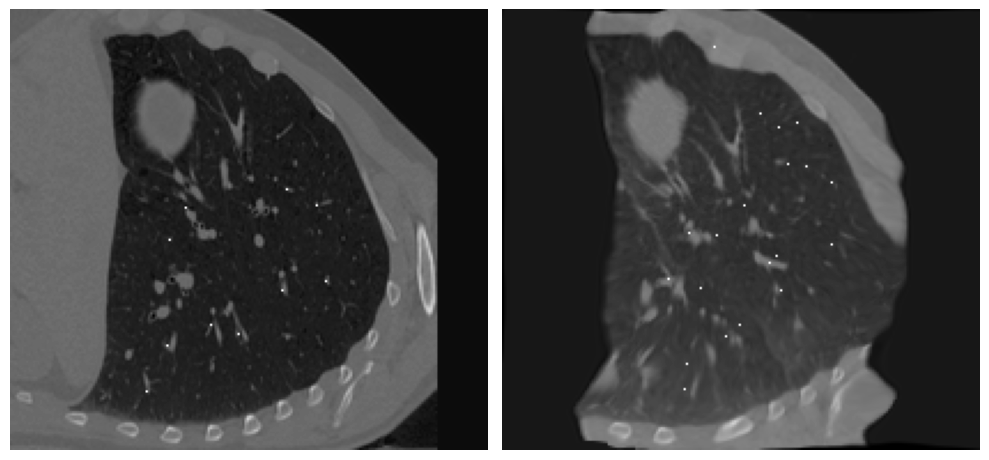

In [14]:
fixed_image = sitk.ReadImage("processed_data/learn2reg/scans/case_001_insp.nii.gz")
moving_image = sitk.ReadImage('registered_data_pytorch.nii.gz')

moving_kps = kps[:, [0, 1, 2]]
fixed_kps = kps[:, [3, 4, 5]]

for p in fixed_kps:
    fixed_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 1)


for p in moving_transformed:
    moving_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 1)



moving_l = sitk.GetArrayFromImage(moving_image)
fixed_l = sitk.GetArrayFromImage(fixed_image)
s = 60


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fixed_l.T[s, :, :], cmap='gray')
axs[0].axis('off')
axs[1].imshow(moving_l.T[s, :, :], cmap='gray')
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [3]:
moving = nib.load("processed_data/learn2reg/scans/case_001_exp.nii.gz")
print(moving.shape)
data_moving = np.expand_dims(moving.get_fdata().squeeze(), axis=(0, -1)).astype(np.float32)
print(data_moving.shape)
input_moving = torch.from_numpy(data_moving).to(device).float().permute(0, 4, 1, 2, 3)
print(input_moving.shape)

(192, 192, 208)
(1, 192, 192, 208, 1)


NameError: name 'device' is not defined

In [32]:
print(fixed_image.GetSize())

(192, 192, 208)


In [30]:
def get_landmarks_image(landmarks: np.ndarray, image_shape: tuple):
    """From a np.ndarray of points, create a labels image. Each point
    will have it's corresponding index in the list as label

    Args:
        landmarks (np.ndarray): list of points
        image_shape (tuple): shape of target image

    Returns:
        lm_img (np.ndarray): labels image
    """
    lm_img = np.zeros(image_shape)
    for i, (x, y, z) in enumerate(landmarks):
        lm_img[x, y, z] = i + 1
    return lm_img

In [39]:
fixed_lmask = get_landmarks_image(fixed_kps.astype(int), fixed_image.GetSize())
fixed_lmask = sitk.GetImageFromArray(fixed_lmask.T)
fixed_lmask.CopyInformation(fixed_image)
sitk.WriteImage(fixed_lmask, "fixed_lmask.nii.gz")

In [40]:
moved_lmask = get_landmarks_image(moving_transformed.astype(int), moving_image.GetSize())
moved_lmask = sitk.GetImageFromArray(moved_lmask.T)
moved_lmask.CopyInformation(moving_image)
sitk.WriteImage(moved_lmask, "moved_lmask.nii.gz")

In [20]:
fixed = nib.load("processed_data/copd_scans/scans/case_001_insp.nii.gz")
fixed2 = nib.load("processed_data/learn2reg/scans/case_001_insp.nii.gz")

# moving = nib.load("processed_data/copd_scans/scans/case_001_exp.nii.gz")

In [21]:
print(fixed)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (224, 224, 96)
affine: 
[[-1.44000006  0.          0.         -0.        ]
 [ 0.         -1.44000006  0.         -0.        ]
 [ 0.          0.         -3.16000009  0.        ]
 [ 0.          0.          0.          1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 224 224  96   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.    1.44  1.44  3.16  0.    0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax      

In [19]:
print(fixed2)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (192, 192, 208)
affine: 
[[-1.75000000e+00  0.00000000e+00  0.00000000e+00  1.86155807e+02]
 [ 0.00000000e+00 -1.25000000e+00  0.00000000e+00  1.10624496e+02]
 [ 0.00000000e+00  0.00000000e+00  1.75000000e+00  1.64400000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 192 192 208   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1.   1.75 1.25 1.75 0.   0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.